In [1]:
import numpy as np
import copy
import matplotlib.pyplot as plt
import seaborn as sb
from matplotlib import cm
import math
from matplotlib.patches import Ellipse

In [2]:
T = 200

delta_t = 1

Q1 = np.zeros((4, 4),float)
np.fill_diagonal(Q1, [1,1,1e-4,1e-4])
Q2 = np.zeros((4, 4),float)
np.fill_diagonal(Q2, [1,1,1e-4,1e-4])
Q2 = Q2 * 2

A = np.zeros((4,4),float)
np.fill_diagonal(A,1)
A[0][2]=delta_t
A[1][3]=delta_t

B = np.zeros((4,2),float)
B[0][0]=delta_t
B[1][1]=delta_t
B[2][0]=1
B[3][1]=1

C = np.zeros((2,4),float)
C[0][0] = 1
C[1][1] = 1

R1 = np.zeros((2, 2),float)
np.fill_diagonal(R1, 100)
R2 = np.zeros((2, 2),float)
np.fill_diagonal(R2, 100)
R2 = R2 * 2

In [3]:
def sample_gaussian(mu, sigma):
  sample = np.random.multivariate_normal(mu.flatten(), sigma)
  return sample

In [4]:
def generate_trajectory(A, B, Q, X, U, T):

# gives 200 points of the generated trajectory, from t = 1 to t = 200

  path = []
  path.append(X.flatten().tolist())
  X_new = copy.deepcopy(X)

  for i in range(1,T+1):
    
    epsilon = sample_gaussian(np.zeros((4,1),float), Q)
    X_new = np.dot(A,X_new) + np.dot(B,np.array(U[i-1]).reshape(2,1)) + epsilon.reshape((4,1))
    path.append(X_new.flatten().tolist())

  return path

In [5]:
def observe_trajectory(C, R, X, T):

  path = []

  for i in range(1,T+1):
    
    delta = sample_gaussian(np.zeros((2,1),float), R)
    Z = np.dot(C,np.array(X[i]).reshape(4,1)) + delta.reshape((2,1))
    path.append(Z.flatten().tolist())

  return path

In [6]:
X_init_1 = np.array([60,20,2,2]).reshape(4,1)
U = np.zeros((T,2,1),float)
actual_trajectory1 = generate_trajectory(A, B, Q1, X_init_1, U, T)
observed_trajectory1 = observe_trajectory(C,R1,actual_trajectory1,T)

In [7]:
def plot_2_continuous(path1,path2,label1,label2):

  x = []
  y = []
  for i in range(len(path1)):
    x.append(path1[i][0])
    y.append(path1[i][1])
  plt.plot(x,y,label = label1)

  x = []
  y = []
  for i in range(len(path2)):
    x.append(path2[i][0])
    y.append(path2[i][1])

  plt.plot(x,y,label = label2)
  plt.xlabel("x (meter)")
  plt.ylabel("y (meter)")
  plt.legend()
  plt.rcParams["figure.figsize"] = (5,5)
  plt.show()

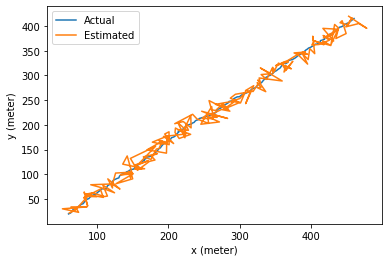

In [8]:
plot_2_continuous(actual_trajectory1,observed_trajectory1,"Actual","Estimated")

In [9]:
X_init_2 = np.array([20,60,2,2]).reshape(4,1)
U = np.zeros((T,2,1),float)
actual_trajectory2 = generate_trajectory(A, B, Q2, X_init_2, U, T)
observed_trajectory2 = observe_trajectory(C,R2,actual_trajectory2,T)

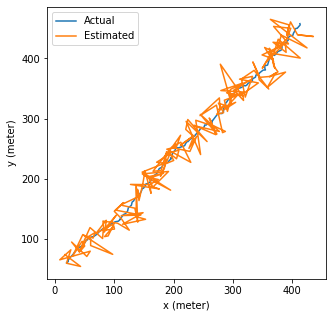

In [10]:
plot_2_continuous(actual_trajectory2,observed_trajectory2,"Actual","Estimated")

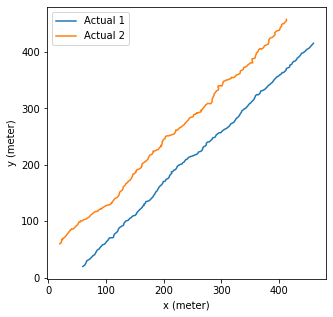

In [11]:
plot_2_continuous(actual_trajectory1,actual_trajectory2,"Actual 1","Actual 2")

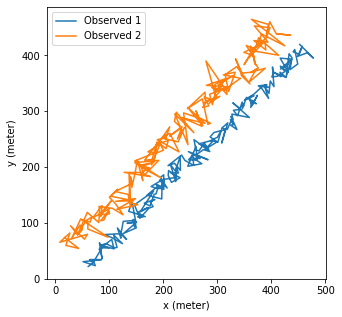

In [12]:
plot_2_continuous(observed_trajectory1,observed_trajectory2,"Observed 1","Observed 2")

In [13]:
def plot_2_trajectory(path1,path2,label1,label2):
  x = []
  y = []
  for i in range(len(path1)):
    if (i%20 == 0):
      x.append(path1[i][0])
      y.append(path1[i][1])
  plt.scatter(x,y,label = label1)
  plt.plot(x,y,linestyle = 'dashed')
  x = []
  y = []
  for i in range(len(path2)):
    if (label2 == "Observed"):
      if ((i+1)%20 == 0):
        x.append(path2[i][0])
        y.append(path2[i][1])
    else:
      if (i%20 == 0):
        x.append(path2[i][0])
        y.append(path2[i][1])
    
  plt.scatter(x,y,label = label2)
  plt.plot(x,y,linestyle = 'dashed')
  plt.xlabel("x (meter)")
  plt.ylabel("y (meter)")
  plt.legend()
  plt.rcParams["figure.figsize"] = (15,15)
  plt.show()

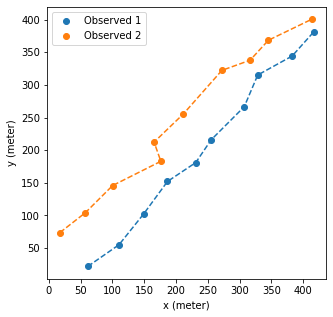

In [14]:
plot_2_trajectory(observed_trajectory1,observed_trajectory2,"Observed 1","Observed 2")

In [15]:
def kalman_filter(update_type, old_mu, old_sigma, u, z, A, B, C,R,Q):

  if update_type == "motion_model":
    
    new_mu = np.dot(A,old_mu)+np.dot(B,u)
    new_sigma = np.dot(np.dot(A,old_sigma),A.T)+Q

  else:

    # Kalman Gain
    K = np.dot(np.dot(old_sigma,C.T),np.linalg.inv(np.dot(np.dot(C,old_sigma),C.T)+R))

    new_mu = old_mu + np.dot(K,z-np.dot(C,old_mu))
    
    I = np.identity(K.shape[0])
    new_sigma = np.dot(I - np.dot(K,C),old_sigma)

  return new_mu, new_sigma

In [16]:
def mahalanobis_distance(mean, cov, point):
  dif = point - mean 
  S_inverse = np.linalg.inv(cov)
  ans = np.dot(dif.T,np.dot(S_inverse,dif))
  return ans[0][0]

In [17]:
mu_belief1 = np.array([20,10,1,1]).reshape(4,1)
sigma_belief1 = np.zeros((4,4),float)
np.fill_diagonal(sigma_belief1, 1e-4)

mu_belief2 = np.array([10,20,1,1]).reshape(4,1)
sigma_belief2 = np.zeros((4,4),float)
np.fill_diagonal(sigma_belief2, 1e-4)

mu_s1 = []
sigma_s1 = []

mu_s2 = []
sigma_s2 = []

mu_s1.append(mu_belief1)
sigma_s1.append(sigma_belief1)

mu_s2.append(mu_belief2)
sigma_s2.append(sigma_belief2)

for i in range(1,T+1):

  Z1 = np.reshape(np.asarray(observed_trajectory1[i-1]),(2,1))
  Z2 = np.reshape(np.asarray(observed_trajectory2[i-1]),(2,1))

  mu_i_1,sigma_i_1 = kalman_filter("motion_model",mu_s1[i-1],sigma_s1[i-1],U[i-1],None,A,B,C,R1,Q1)
  mu_i_2,sigma_i_2 = kalman_filter("motion_model",mu_s2[i-1],sigma_s2[i-1],U[i-1],None,A,B,C,R1,Q1)

  d1 = mahalanobis_distance(mu_i_1[:2],sigma_i_1[:2,:2],Z1)
  d2 = mahalanobis_distance(mu_i_1[:2],sigma_i_1[:2,:2],Z2)
  d3 = mahalanobis_distance(mu_i_2[:2],sigma_i_2[:2,:2],Z1)
  d4 = mahalanobis_distance(mu_i_2[:2],sigma_i_2[:2,:2],Z2)

  if (d1+d4 < d2+d3):
    mu_i_1,sigma_i_1 = kalman_filter("sensor_model",mu_i_1,sigma_i_1,U[i-1],Z1,A,B,C,R1,Q1)
    mu_i_2,sigma_i_2 = kalman_filter("sensor_model",mu_i_2,sigma_i_2,U[i-1],Z2,A,B,C,R2,Q2)
  else:
    mu_i_1,sigma_i_1 = kalman_filter("sensor_model",mu_i_1,sigma_i_1,U[i-1],Z2,A,B,C,R1,Q1)
    mu_i_2,sigma_i_2 = kalman_filter("sensor_model",mu_i_2,sigma_i_2,U[i-1],Z1,A,B,C,R2,Q2)

  mu_s1.append(mu_i_1)
  sigma_s1.append(sigma_i_1)

  mu_s2.append(mu_i_2)
  sigma_s2.append(sigma_i_2)

In [18]:
estimated_trajectory1 = []
estimated_trajectory2 = []

for i in range(0,T+1):
  estimated_trajectory1.append(mu_s1[i].reshape(4,).tolist())
  estimated_trajectory2.append(mu_s2[i].reshape(4,).tolist())

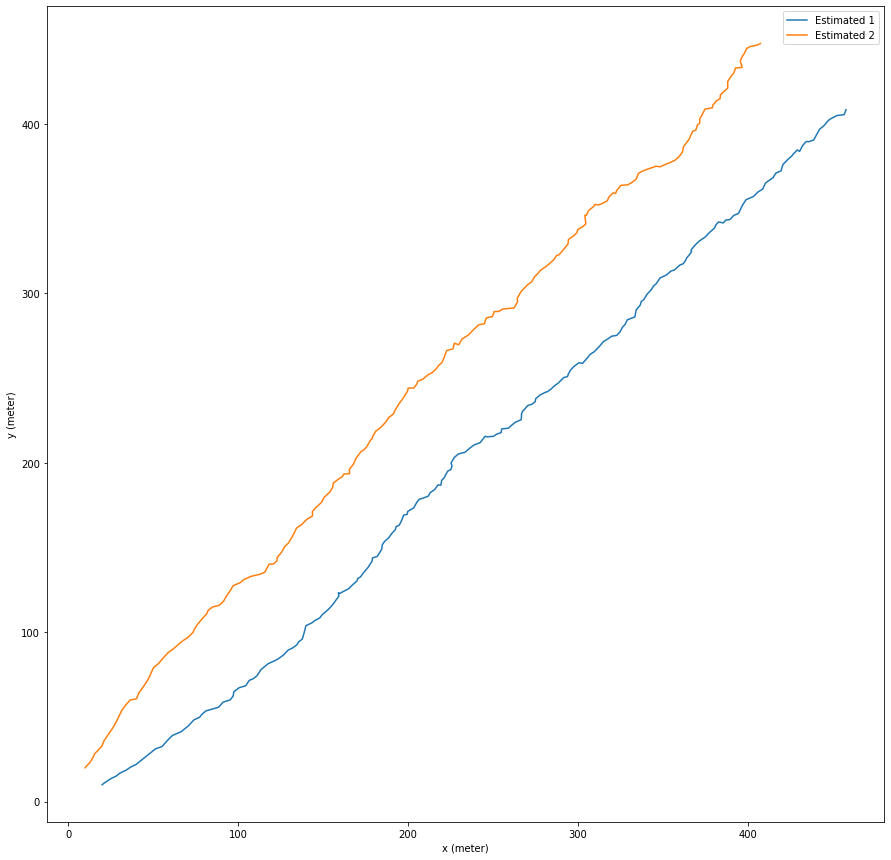

In [19]:
plot_2_continuous(estimated_trajectory1,estimated_trajectory2,"Estimated 1","Estimated 2")

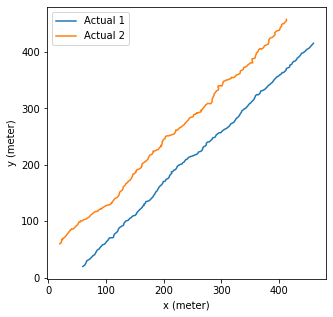

In [20]:
plot_2_continuous(actual_trajectory1,actual_trajectory2,"Actual 1","Actual 2")

In [21]:
def plot_4_continuous(path1,path2,path3,path4,label1,label2,label3,label4):

  x = []
  y = []
  for i in range(len(path1)):
    x.append(path1[i][0])
    y.append(path1[i][1])
  plt.plot(x,y,label = label1)

  x = []
  y = []
  for i in range(len(path2)):
    x.append(path2[i][0])
    y.append(path2[i][1])

  plt.plot(x,y,label = label2)

  x = []
  y = []
  for i in range(len(path3)):
    x.append(path3[i][0])
    y.append(path3[i][1])

  plt.plot(x,y,label = label3)

  x = []
  y = []
  for i in range(len(path4)):
    x.append(path4[i][0])
    y.append(path4[i][1])

  plt.plot(x,y,label = label4)
  plt.rcParams["figure.figsize"] = (15,15)

  plt.xlabel("x (meter)")
  plt.ylabel("y (meter)")
  plt.legend()
  plt.show()

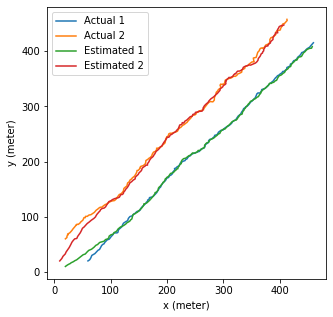

In [22]:
plot_4_continuous(actual_trajectory1,actual_trajectory2,estimated_trajectory1,estimated_trajectory2,"Actual 1","Actual 2","Estimated 1","Estimated 2")